## Airline On-time Analysis - Remedy Partners Case Study - Angela Fogel

### Import required packages

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
import sklearn.utils
from IPython.display import HTML, display
import seaborn as sns
import time
import warnings 
warnings.simplefilter("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
%matplotlib inline

### Import Airline On-time Data (January 2017-May 2018) from .csv File:
#### Data source: https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time

In [138]:
data1 = pd.read_csv('airlineData.csv', error_bad_lines=False)

### Import Airline/Airport Name Lookup Tables

In [3]:
ALnames = pd.read_csv('airlineNames.csv', error_bad_lines=False)
APnames = pd.read_csv('airportNames.csv', error_bad_lines=False)

### Rename CRS time to SCHEDULED time for clarity
### Drop missing data records

In [139]:
data1.rename(columns = {'CRS_DEP_TIME':'SCHEDULED_DEP_TIME'}, inplace = True)
data1.rename(columns = {'CRS_ARR_TIME':'SCHEDULED_ARR_TIME'}, inplace = True)
data1.rename(columns = {'DEP_TIME':'ACTUAL_DEP_TIME'}, inplace = True)
data1.rename(columns = {'ARR_TIME':'ACTUAL_ARR_TIME'}, inplace = True)
data1.rename(columns = {'':'UNNAMED'}, inplace = True)
data1.replace([np.inf, -np.inf], np.nan, inplace=True)
data1.dropna(subset=['ACTUAL_DEP_TIME'], inplace=True)
data1.dropna(subset=['SCHEDULED_DEP_TIME'], inplace=True)
data1.dropna(subset=['ACTUAL_ARR_TIME'], inplace=True)
data1.dropna(subset=['SCHEDULED_ARR_TIME'], inplace=True)
data1.dropna(subset=['ACTUAL_DEP_TIME'], inplace=True)
data1.dropna(subset=['SCHEDULED_DEP_TIME'], inplace=True)
data1.dropna(subset=['ACTUAL_ARR_TIME'], inplace=True)
data1.dropna(subset=['SCHEDULED_ARR_TIME'], inplace=True)
data1.dropna(subset=['ACTUAL_ELAPSED_TIME'], inplace=True)
data1.drop(['Unnamed: 34'], axis=1, inplace=True)

In [140]:
list(data1.columns.values)

['YEAR',
 'QUARTER',
 'MONTH',
 'AIRLINE_ID',
 'FL_NUM',
 'ORIGIN_AIRPORT_ID',
 'ORIGIN',
 'ORIGIN_CITY_NAME',
 'DEST_AIRPORT_ID',
 'DEST',
 'DEST_CITY_NAME',
 'SCHEDULED_DEP_TIME',
 'ACTUAL_DEP_TIME',
 'DEP_DELAY_NEW',
 'DEP_DEL15',
 'TAXI_OUT',
 'WHEELS_OFF',
 'WHEELS_ON',
 'TAXI_IN',
 'SCHEDULED_ARR_TIME',
 'ACTUAL_ARR_TIME',
 'ARR_DELAY_NEW',
 'CANCELLED',
 'DIVERTED',
 'CRS_ELAPSED_TIME',
 'ACTUAL_ELAPSED_TIME',
 'AIR_TIME',
 'FLIGHTS',
 'DISTANCE',
 'CARRIER_DELAY',
 'WEATHER_DELAY',
 'NAS_DELAY',
 'SECURITY_DELAY',
 'LATE_AIRCRAFT_DELAY']

In [141]:
data1.dtypes

YEAR                     int64
QUARTER                  int64
MONTH                    int64
AIRLINE_ID               int64
FL_NUM                   int64
ORIGIN_AIRPORT_ID        int64
ORIGIN                  object
ORIGIN_CITY_NAME        object
DEST_AIRPORT_ID          int64
DEST                    object
DEST_CITY_NAME          object
SCHEDULED_DEP_TIME       int64
ACTUAL_DEP_TIME        float64
DEP_DELAY_NEW          float64
DEP_DEL15              float64
TAXI_OUT               float64
WHEELS_OFF             float64
WHEELS_ON              float64
TAXI_IN                float64
SCHEDULED_ARR_TIME       int64
ACTUAL_ARR_TIME        float64
ARR_DELAY_NEW          float64
CANCELLED              float64
DIVERTED               float64
CRS_ELAPSED_TIME       float64
ACTUAL_ELAPSED_TIME    float64
AIR_TIME               float64
FLIGHTS                float64
DISTANCE               float64
CARRIER_DELAY          float64
WEATHER_DELAY          float64
NAS_DELAY              float64
SECURITY

### Convert NaN values

In [142]:
data1.fillna({'YEAR':0, 'QUARTER':0, 'MONTH':0, 'DAY_OF_MONTH':0, 'DAY_OF_WEEK':0, 'AIRLINE_ID':0, 'ORIGIN_AIRPORT_ID':0, 'ORIGIN_AIRPORT_SEQ_ID':0, 'DEST_AIRPORT_ID':0, 'DEP_DELAY_NEW':0,'DEP_DEL15':0,'DEP_DELAY_GROUP':0, 'TAXI_OUT':0, 'WHEELS_OFF':0, 'WHEELS_ON':0, 'TAXI_IN':0, 'ARR_DELAY':0, 'ARR_DELAY_NEW':0, 'ARR_DEL15':0, 'ARR_DEL_GROUP':0, 'ARR_TIME_BLK':0, 'CRS_ELAPSED_TIME':0, 'ACCTUAL_ELAPSED_TIME':0, 'AIR_TIME':0, 'FLIGHTS':0, 'DISTANCE':0, 'DISTANCE_GROUP':0, 'CARRIER_DELAY':0, 'WEATHER_DELAY':0, 'NAS_DELAY':0, 'SECURITY_DELAY':0, 'LATE_AIRCRAFT_DELAY':0, 'DIV_AIRPORT_LANDINGS':0}, inplace=True)

,YEAR,QUARTER,MONTH,AIRLINE_ID,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,SCHEDULED_DEP_TIME,ACTUAL_DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,SCHEDULED_ARR_TIME,ACTUAL_ARR_TIME,ARR_DELAY_NEW,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,2017,4,10,19393,4182,10140,ABQ,"Albuquerque, NM",12892,LAX,"Los Angeles, CA",1945,1956.0,11.0,0.0,7.0,2003.0,2032.0,5.0,2050,2037.0,0.0,0.0,0.0,125.0,101.0,89.0,1.0,677.0,0.0,0.0,0.0,0.0,0.0
1,2017,4,10,19393,1486,10140,ABQ,"Albuquerque, NM",13198,MCI,"Kansas City, MO",720,717.0,0.0,0.0,8.0,725.0,956.0,4.0,1010,1000.0,0.0,0.0,0.0,110.0,103.0,91.0,1.0,718.0,0.0,0.0,0.0,0.0,0.0
2,2017,4,10,19393,113,10140,ABQ,"Albuquerque, NM",13232,MDW,"Chicago, IL",810,809.0,0.0,0.0,9.0,818.0,1134.0,7.0,1155,1141.0,0.0,0.0,0.0,165.0,152.0,136.0,1.0,1121.0,0.0,0.0,0.0,0.0,0.0
3,2017,4,10,19393,654,10140,ABQ,"Albuquerque, NM",13232,MDW,"Chicago, IL",1700,1656.0,0.0,0.0,7.0,1703.0,2028.0,3.0,2040,2031.0,0.0,0.0,0.0,160.0,155.0,145.0,1.0,1121.0,0.0,0.0,0.0,0.0,0.0
4,2017,4,10,19393,323,10140,ABQ,"Albuquerque, NM",13796,OAK,"Oakland, CA",1925,1942.0,17.0,1.0,9.0,1951.0,2044.0,5.0,2055,2049.0,0.0,0.0,0.0,150.0,127.0,113.0,1.0,889.0,0.0,0.0,0.0,0.0,0.0
5,2017,4,10,19393,1344,10140,ABQ,"Albuquerque, NM",13796,OAK,"Oakland, CA",1240,1241.0,1.0,0.0,7.0,1248.0,1343.0,18.0,1410,1401.0,0.0,0.0,0.0,150.0,140.0,115.0,1.0,889.0,0.0,0.0,0.0,0.0,0.0
6,2017,4,10,19393,4919,10140,ABQ,"Albuquerque, NM",13796,OAK,"Oakland, CA",640,639.0,0.0,0.0,6.0,645.0,744.0,4.0,810,748.0,0.0,0.0,0.0,150.0,129.0,119.0,1.0,889.0,0.0,0.0,0.0,0.0,0.0
7,2017,4,10,19393,594,10140,ABQ,"Albuquerque, NM",14107,PHX,"Phoenix, AZ",1100,1101.0,1.0,0.0,7.0,1108.0,1101.0,4.0,1120,1105.0,0.0,0.0,0.0,80.0,64.0,53.0,1.0,328.0,0.0,0.0,0.0,0.0,0.0
8,2017,4,10,19393,806,10140,ABQ,"Albuquerque, NM",14107,PHX,"Phoenix, AZ",1735,1753.0,18.0,1.0,24.0,1817.0,1810.0,8.0,1750,1818.0,28.0,0.0,0.0,75.0,85.0,53.0,1.0,328.0,0.0,0.0,19.0,0.0,9.0
9,2017,4,10,19393,1812,10140,ABQ,"Albuquerque, NM",14107,PHX,"Phoenix, AZ",750,749.0,0.0,0.0,8.0,757.0,749.0,7.0,810,756.0,0.0,0.0,0.0,80.0,67.0,52.0,1.0,328.0,0.0,0.0,0.0,0.0,0.0


In [143]:
data1.isnull().values.any()

False

In [144]:
data1.columns[data1.isnull().any()].tolist()

[]

### Calculate Elapsed Time Delay (CRS_ELAPSED_TIME = Scheduled Elapsed Time)

In [145]:
data1['ELAPSED_DELAY'] = data1['ACTUAL_ELAPSED_TIME']-data1['CRS_ELAPSED_TIME']

## Lookup Airline and Airport Names

In [146]:
data1 = pd.merge(data1, ALnames, how='left',
        left_on='AIRLINE_ID', right_on='Code')
data1.rename(columns = {'Description':'AIRLINE'}, inplace = True)

In [147]:
data1.drop(['Code'], axis=1, inplace=True)

In [148]:
data1 = pd.merge(data1, APnames, how='left', left_on='ORIGIN_AIRPORT_ID', right_on='Code')

In [149]:
data1=data1.rename(columns = {'Description':'ORIGIN_AIRPORT'})

In [150]:
data1.drop(['Code'], axis=1, inplace=True)

In [151]:
data1 = pd.merge(data1, APnames, how='left', left_on='DEST_AIRPORT_ID', right_on='Code')

In [152]:
data1=data1.rename(columns = {'Description':'DEST_AIRPORT'})

In [153]:
data1.drop(['Code'], axis=1, inplace=True)

In [154]:
data1.drop(data1[data1.ELAPSED_DELAY < 0].index, inplace=True)

### Calculate Pairwise Correlations

In [155]:
print(data1.corr())

                         YEAR   QUARTER     MONTH  AIRLINE_ID    FL_NUM  \
YEAR                 1.000000 -0.458941 -0.473201    0.137792  0.131106   
QUARTER             -0.458941  1.000000  0.968624   -0.042365 -0.039121   
MONTH               -0.473201  0.968624  1.000000   -0.043109 -0.040558   
AIRLINE_ID           0.137792 -0.042365 -0.043109    1.000000  0.260779   
FL_NUM               0.131106 -0.039121 -0.040558    0.260779  1.000000   
ORIGIN_AIRPORT_ID   -0.024134  0.007601  0.007891    0.005072 -0.010872   
DEST_AIRPORT_ID     -0.024192  0.001080  0.001323    0.003302 -0.023873   
SCHEDULED_DEP_TIME  -0.002218 -0.007223 -0.006976    0.001588  0.014362   
ACTUAL_DEP_TIME     -0.002802 -0.009053 -0.009205   -0.000878  0.017819   
DEP_DELAY_NEW       -0.006119 -0.013121 -0.016311    0.034671  0.021188   
DEP_DEL15           -0.011376 -0.021949 -0.024922   -0.006658  0.005120   
TAXI_OUT             0.047609 -0.003268 -0.004123    0.176437  0.091227   
WHEELS_OFF           0.00

### Show Major Correlations

In [156]:
print( data1[['ARR_DELAY_NEW','DEP_DELAY_NEW', 'ELAPSED_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'CARRIER_DELAY', 'LATE_AIRCRAFT_DELAY', 'NAS_DELAY']].corr())

                     ARR_DELAY_NEW  DEP_DELAY_NEW  ELAPSED_DELAY  TAXI_OUT  \
ARR_DELAY_NEW             1.000000       0.969495       0.338010  0.235908   
DEP_DELAY_NEW             0.969495       1.000000       0.103617  0.096383   
ELAPSED_DELAY             0.338010       0.103617       1.000000  0.593641   
TAXI_OUT                  0.235908       0.096383       0.593641  1.000000   
WHEELS_OFF                0.142397       0.130744       0.052224  0.060068   
CARRIER_DELAY             0.643177       0.673291       0.040727  0.042000   
LATE_AIRCRAFT_DELAY       0.545974       0.562425       0.050832  0.047271   
NAS_DELAY                 0.528454       0.407926       0.561748  0.350365   

                     WHEELS_OFF  CARRIER_DELAY  LATE_AIRCRAFT_DELAY  NAS_DELAY  
ARR_DELAY_NEW          0.142397       0.643177             0.545974   0.528454  
DEP_DELAY_NEW          0.130744       0.673291             0.562425   0.407926  
ELAPSED_DELAY          0.052224       0.040727        

### Calculate Average Monthly Arrival Delay

In [157]:
avgMonthlyLabels = data1[['MONTH', 'ARR_DELAY_NEW']]
avgMonthlyGroup=avgMonthlyLabels.groupby('MONTH')
avgMonthlyMean=avgMonthlyGroup.mean().sort_values(by=['ARR_DELAY_NEW'])

In [158]:
print(avgMonthlyMean)

       ARR_DELAY_NEW
MONTH               
11         14.327644
9          15.631859
10         16.806283
3          19.038300
2          21.281829
4          22.216459
5          22.526098
8          22.548611
12         23.457332
1          24.256367
7          25.151160
6          25.827995


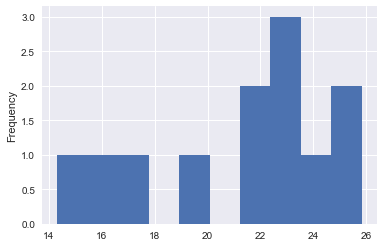

In [159]:
avgMonthlyMean.ARR_DELAY_NEW.plot.hist()

### Filter Outliers

In [202]:
dataF=data1[data1['ARR_DELAY_NEW'] <=25]

In [182]:
dataF.describe()

,YEAR,QUARTER,MONTH,AIRLINE_ID,FL_NUM,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,SCHEDULED_DEP_TIME,ACTUAL_DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,SCHEDULED_ARR_TIME,ACTUAL_ARR_TIME,ARR_DELAY_NEW,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,ELAPSED_DELAY
count,1.867984e+06,1.867984e+06,1.867984e+06,1.867984e+06,1.867984e+06,1.867984e+06,1.867984e+06,1.867984e+06,1.867984e+06,1.867984e+06,1.867984e+06,1.867984e+06,1.867984e+06,1.867984e+06,1.867984e+06,1.867984e+06,1.867984e+06,1.867984e+06,1867984.0,1867984.0,1.867984e+06,1.867984e+06,1.867984e+06,1867984.0,1.867984e+06,1.867984e+06,1.867984e+06,1.867984e+06,1.867984e+06,1.867984e+06,1.867984e+06
mean,2.017339e+03,2.126366e+00,5.316857e+00,1.996586e+04,2.314427e+03,1.272910e+04,1.275915e+04,1.274860e+03,1.267643e+03,1.537133e+00,2.915014e-02,2.097664e+01,1.299137e+03,1.431912e+03,9.328925e+00,1.441940e+03,1.438506e+03,5.774010e+00,0.0,0.0,1.399010e+02,1.467309e+02,1.164253e+02,1.0,8.034447e+02,4.945016e-01,3.475030e-02,1.914020e+00,4.806251e-03,3.774625e-01,6.829824e+00
std,4.732848e-01,1.065901e+00,3.265538e+00,3.820095e+02,1.843705e+03,1.532719e+03,1.526555e+03,4.867946e+02,4.901717e+02,3.991001e+00,1.682273e-01,9.770943e+00,4.903497e+02,5.065978e+02,7.218615e+00,5.044053e+02,5.108661e+02,6.967797e+00,0.0,0.0,7.683043e+01,7.796498e+01,7.668642e+01,0.0,6.187739e+02,2.521054e+00,6.996143e-01,5.442832e+00,2.529546e-01,2.243951e+00,6.504576e+00
min,2.017000e+03,1.000000e+00,1.000000e+00,1.939300e+04,1.000000e+00,1.013500e+04,1.013500e+04,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.0,0.0,1.800000e+01,1.800000e+01,8.000000e+00,1.0,3.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.017000e+03,1.000000e+00,3.000000e+00,1.979000e+04,7.290000e+02,1.129200e+04,1.129200e+04,8.370000e+02,8.350000e+02,0.000000e+00,0.000000e+00,1.400000e+01,8.570000e+02,1.025000e+03,5.000000e+00,1.030000e+03,1.031000e+03,0.000000e+00,0.0,0.0,8.500000e+01,9.000000e+01,6.000000e+01,1.0,3.410000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
50%,2.017000e+03,2.000000e+00,5.000000e+00,1.993000e+04,1.794000e+03,1.289200e+04,1.289200e+04,1.230000e+03,1.227000e+03,0.000000e+00,0.000000e+00,1.900000e+01,1.245000e+03,1.424000e+03,7.000000e+00,1.430000e+03,1.429000e+03,3.000000e+00,0.0,0.0,1.200000e+02,1.270000e+02,9.600000e+01,1.0,6.280000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00
75%,2.018000e+03,3.000000e+00,8.000000e+00,2.030400e+04,3.702000e+03,1.410000e+04,1.410000e+04,1.700000e+03,1.657000e+03,0.000000e+00,0.000000e+00,2.600000e+01,1.715000e+03,1.841000e+03,1.100000e+01,1.847000e+03,1.848000e+03,1.000000e+01,0.0,0.0,1.720000e+02,1.800000e+02,1.490000e+02,1.0,1.047000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01
max,2.018000e+03,4.000000e+00,1.200000e+01,2.117100e+04,8.402000e+03,1.621800e+04,1.621800e+04,2.359000e+03,2.400000e+03,2.370000e+02,1.000000e+00,1.300000e+02,2.400000e+03,2.400000e+03,9.400000e+01,2.400000e+03,2.400000e+03,2.500000e+01,0.0,0.0,7.180000e+02,7.240000e+02,6.960000e+02,1.0,4.983000e+03,2.500000e+01,2.500000e+01,2.500000e+01,2.400000e+01,2.500000e+01,6.300000e+01


### Calculate Delay Reason Percentages

In [200]:
carrierPercent=(dataF['CARRIER_DELAY'].sum())/((dataF['CARRIER_DELAY'].sum())+(dataF['WEATHER_DELAY'].sum())+(dataF['NAS_DELAY'].sum())+(dataF['SECURITY_DELAY'].sum())+
                                             (dataF['LATE_AIRCRAFT_DELAY'].sum()))
aircraftPercent=(dataF['LATE_AIRCRAFT_DELAY'].sum())/((dataF['CARRIER_DELAY'].sum())+(dataF['WEATHER_DELAY'].sum())+(dataF['NAS_DELAY'].sum())+(dataF['SECURITY_DELAY'].sum())+
                                             (dataF['LATE_AIRCRAFT_DELAY'].sum()))
NASPercent=(dataF['NAS_DELAY'].sum())/((dataF['CARRIER_DELAY'].sum())+(dataF['WEATHER_DELAY'].sum())+(dataF['NAS_DELAY'].sum())+(dataF['SECURITY_DELAY'].sum())+
                                             (dataF['LATE_AIRCRAFT_DELAY'].sum()))
weatherPercent=(dataF['WEATHER_DELAY'].sum())/((dataF['CARRIER_DELAY'].sum())+(dataF['WEATHER_DELAY'].sum())+(dataF['NAS_DELAY'].sum())+(dataF['SECURITY_DELAY'].sum())+
                                             (dataF['LATE_AIRCRAFT_DELAY'].sum()))
securityPercent=(dataF['SECURITY_DELAY'].sum())/((dataF['CARRIER_DELAY'].sum())+(dataF['WEATHER_DELAY'].sum())+(dataF['NAS_DELAY'].sum())+(dataF['SECURITY_DELAY'].sum())+
                                             (dataF['LATE_AIRCRAFT_DELAY'].sum()))

In [201]:
print("Late Aircraft Delay Percent {:.2%} ".format(aircraftPercent))
print("Carrier Delay Percent {:.2%}".format(carrierPercent))
print("NAS Delay Percent {:.2%}".format(NASPercent))
print("Weather Delay Percent {:.2%}".format(weatherPercent))
print("Security Percent {:.3%}".format(securityPercent))

Late Aircraft Delay Percent 34.73% 
Carrier Delay Percent 29.40%
NAS Delay Percent 25.54%
Weather Delay Percent 10.21%
Security Percent 0.126%


## SUMMARIZE DELAYS BY AIRLINE

In [203]:
airlineLabels1 = dataF[['AIRLINE','ARR_DELAY_NEW','DEP_DELAY_NEW','ELAPSED_DELAY']]
airlineGroup1=airlineLabels1.groupby('AIRLINE')
airlineMean1=airlineGroup1.mean().sort_values(by=['ARR_DELAY_NEW'])
airlineMean1.reindex_axis(airlineMean1.mean().sort_values().index, axis=1)

,DEP_DELAY_NEW,ARR_DELAY_NEW,ELAPSED_DELAY
AIRLINE,,,
Hawaiian Airlines Inc.: HA,1.529234,3.925510,4.362843
SkyWest Airlines Inc.: OO,0.943537,4.884565,7.301986
Mesa Airlines Inc.: YV,1.102405,4.921933,6.563566
ExpressJet Airlines Inc.: EV,1.002171,4.980096,7.408128
Spirit Air Lines: NK,1.185219,5.044879,6.984407
Alaska Airlines Inc.: AS,1.015100,5.095363,8.164953
Endeavor Air Inc.: 9E,1.172040,5.453020,7.309449
Allegiant Air: G4,1.852371,5.520182,6.367003
Republic Airline: YX,0.931313,5.543984,7.974443


### Chart Average Arrival Delay, Average Departure Delay and Average Elapsed Time Delay

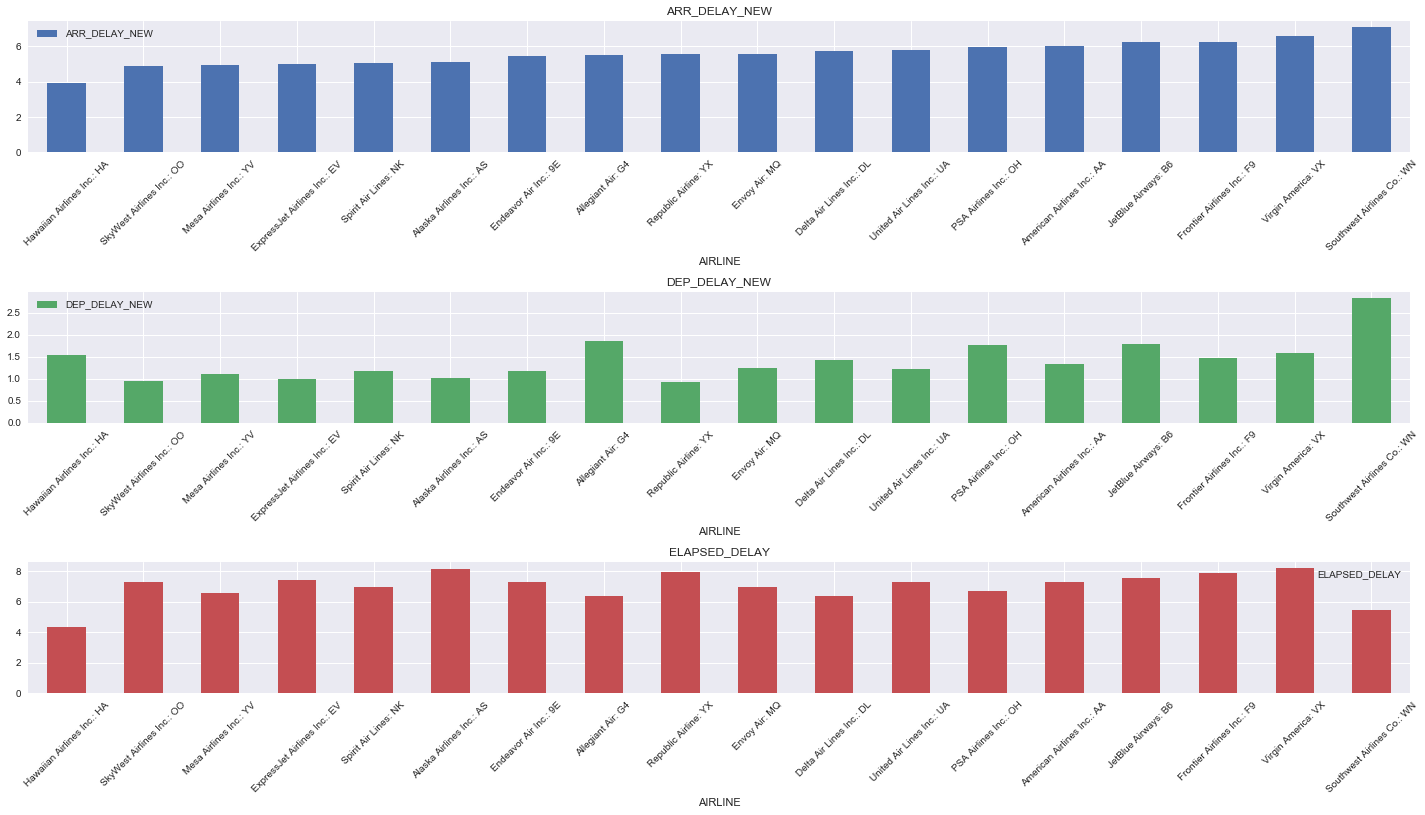

In [204]:
fig, ax = plt.subplots(figsize=(20,100))
#ax.set_xlim([min(x), max(x)]) 
airlineMean1.plot.bar(subplots=True, layout=(27,1), ax=ax, rot=45)
#ax.tick_params(axis='x', which='minor', labelsize='small', labelcolor='m', rot=30)
plt.tight_layout()

### Filter Flight delays only:

In [205]:
data2=dataF[data1.ARR_DELAY_NEW>0]

### Calculate Elapsed Time Delay 

In [206]:
data2['ELAPSED_DELAY'] = data2['ACTUAL_ELAPSED_TIME']-data2['CRS_ELAPSED_TIME']

## SUMMARIZE DELAYS BY AIRLINE (DELAYED FLIGHTS ONLY)

### Average Arrival, Departure and Elapsed Time Delay by Airline

In [207]:
airlineLabels2 = data2[['AIRLINE','ARR_DELAY_NEW','DEP_DELAY_NEW','ELAPSED_DELAY']]
airlineGroup2=airlineLabels2.groupby('AIRLINE')
airlineMean2=airlineGroup2.mean().sort_values(by=['ARR_DELAY_NEW','DEP_DELAY_NEW','ELAPSED_DELAY'])
airlineMean2.reindex_axis(airlineMean2.mean().sort_values().index, axis=1)

,DEP_DELAY_NEW,ARR_DELAY_NEW,ELAPSED_DELAY
AIRLINE,,,
Hawaiian Airlines Inc.: HA,3.175233,8.150754,6.679919
Mesa Airlines Inc.: YV,1.976742,8.825610,9.707230
SkyWest Airlines Inc.: OO,1.728681,8.949147,10.776814
Delta Air Lines Inc.: DL,2.230643,9.029722,8.867839
ExpressJet Airlines Inc.: EV,1.858430,9.235115,11.148479
PSA Airlines Inc.: OH,2.756168,9.336836,8.905726
Envoy Air: MQ,2.084115,9.346932,9.993749
Spirit Air Lines: NK,2.197929,9.355470,10.417499
American Airlines Inc.: AA,2.087078,9.386830,9.943139


### Plot Average Arrival Delay, Departure Delay and Elapsed Time Delay by Airline

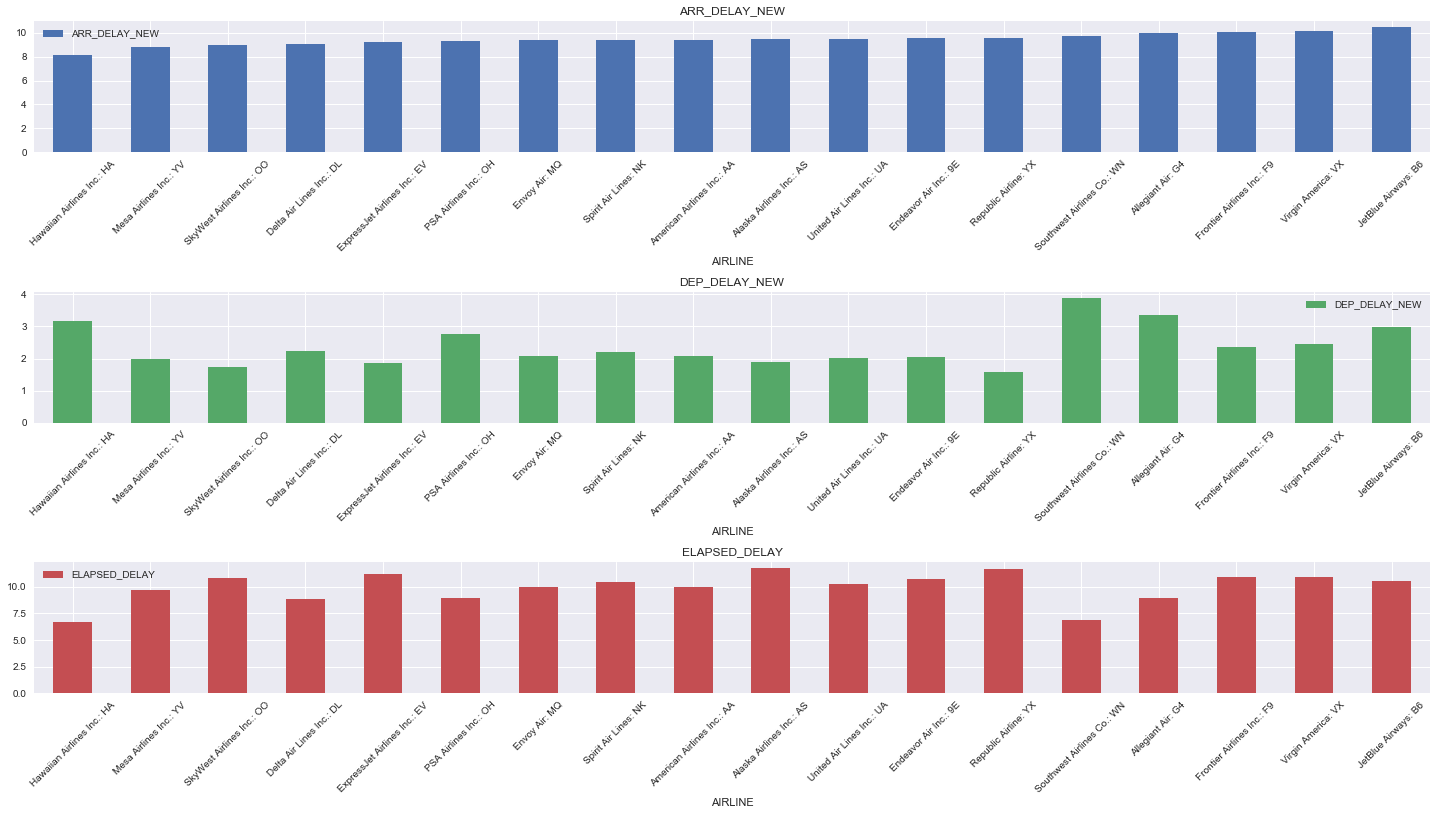

In [208]:
fig, ax = plt.subplots(figsize=(20,100))
airlineMean2.plot.bar(subplots=True, layout=(27,1), ax=ax, rot=45)
#ax.tick_params(axis='x', which='minor', labelsize='small', labelcolor='m', rot=30)
plt.tight_layout()

## REGRESSION / PREDICTION

In [236]:
X = data2[['CARRIER_DELAY', 'LATE_AIRCRAFT_DELAY']].astype(float) 
Y = data2['ARR_DELAY_NEW'].astype(float)
  
# sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)
 
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 8.28082702349
Coefficients: 
 [ 0.79467492  0.76443946]


In [227]:
dataPred=data1.copy()

### Label Records For Training as Delay or No Delay

In [215]:
dataPred['delay'] = np.where(dataPred['ARR_DELAY_NEW']>0, 'delay', 'no_delay')

### Drop Text Fields Not Appropriate for Prediction Algorithms

In [231]:
dataPred.drop(['ORIGIN', 'ORIGIN_CITY_NAME', 'DEST', 'DEST_CITY_NAME','AIRLINE','ORIGIN_AIRPORT', 'DEST_AIRPORT'], axis=1, inplace=True)

In [233]:
#df3_x=dataPred.iloc[:,0:-1]
#df3_y=dataPred.iloc[:,-1]
#x3_train, x3_test, y3_train, y3_test = train_test_split(df3_x, df3_y, test_size=0.2, random_state=4)
#rf3=RandomForestClassifier(n_estimators=1000)
#rf3.fit(x3_train,y3_train)
#predictions3 = rf3.predict(x3_test)
#y3_predict = rf3.predict(x3_test)
#print("Accuracy Score:  ", accuracy_score(y3_test, y3_predict))